# 1. Introduction

The document will walk you through the codes to build the churn model using Python. All the process are highlighted using heading

# 2. Load Dataset

In [66]:
import pandas
import random
import pandas as pd
from datetime import datetime
import dateutil
from dateutil.parser import parse
import numpy as np
from sklearn import preprocessing
from collections import defaultdict

import json
from pprint import pprint

with open('challenge.json') as f:
    data = json.load(f)

In [67]:
df1 = pd.DataFrame.from_records(data)

In [68]:
df1.describe()

,branch_id,customer_code,group_code,item_code,item_total_price,order_id,quantity,sales_channel,segment_code,seller_code,total_price,unit_price
count,204428.00,204428.00,204428.00,204428.00,204428.00,204428.00,204428.00,204428.00,204428.00,204428.00,204428.00,204428.00
mean,0.00,447.49,0.31,1437.30,304.05,12434.09,12.33,1.76,0.85,145.54,5337.07,47.46
std,0.00,246.68,0.71,903.17,1009.27,6935.62,53.30,2.93,1.62,75.20,21268.86,145.30
min,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.01,0.01
25%,0.00,221.00,0.00,631.00,79.60,6497.75,3.00,0.00,0.00,83.00,1180.47,14.67
50%,0.00,486.00,0.00,1455.00,156.15,12698.00,6.00,0.00,0.00,156.00,2035.82,21.78
75%,0.00,651.00,0.00,2048.00,293.86,18280.00,12.00,2.00,2.00,195.00,3611.07,46.72
max,0.00,837.00,3.00,2980.00,102951.11,24617.00,7000.00,105.00,7.00,289.00,428976.46,26280.00


### 2.1 Simple examination of how the data looks like

In [69]:
df1.head() #list the first 5 records

,branch_id,customer_code,group_code,is_churn,item_code,item_total_price,order_id,quantity,register_date,sales_channel,segment_code,seller_code,total_price,unit_price
0,0,143,0,0,854,292.91,21804,10,2017-11-10T00:00:00Z,0,0,190,1613.53,25.04
1,0,433,0,0,246,287.19,5486,20,2011-05-16T00:00:00Z,1,5,153,11163.69,12.33
2,0,486,0,0,1420,184.84,22662,12,2018-01-24T00:00:00Z,0,0,166,6432.12,12.80
3,0,107,0,0,1963,189.18,3956,18,2010-07-28T00:00:00Z,1,0,156,831.82,10.51
4,0,768,0,0,1786,66.87,4730,5,2010-12-17T00:00:00Z,1,0,218,1736.48,11.82


In [70]:
df1['register_date']  = pd.to_datetime(df1['register_date']) 

In [71]:
df1['month'] = df1['register_date'].map(lambda x: x.month)
df1['year'] = df1['register_date'].map(lambda x: x.year)
df1['day'] = df1['register_date'].map(lambda x: x.day)

In [72]:
df1['Qtr'] = df1['register_date'].dt.quarter

In [73]:
df1.head()

,branch_id,customer_code,group_code,is_churn,item_code,item_total_price,order_id,quantity,register_date,sales_channel,segment_code,seller_code,total_price,unit_price,month,year,day,Qtr
0,0,143,0,0,854,292.91,21804,10,2017-11-10,0,0,190,1613.53,25.04,11,2017,10,4
1,0,433,0,0,246,287.19,5486,20,2011-05-16,1,5,153,11163.69,12.33,5,2011,16,2
2,0,486,0,0,1420,184.84,22662,12,2018-01-24,0,0,166,6432.12,12.80,1,2018,24,1
3,0,107,0,0,1963,189.18,3956,18,2010-07-28,1,0,156,831.82,10.51,7,2010,28,3
4,0,768,0,0,1786,66.87,4730,5,2010-12-17,1,0,218,1736.48,11.82,12,2010,17,4


In [94]:
df1['is_churn'].value_counts() #check target counts

0    163799
1     38714
Name: is_churn, dtype: int64

In [95]:
df1['group_code'].value_counts()

0    170164
2     24703
1      7646
3      1915
Name: group_code, dtype: int64

In [77]:
df1['sales_channel'].value_counts()

0     103960
1      47961
6      25960
7      11355
2       6068
8       4655
4       3483
9        463
11       233
5        204
10        76
3         10
Name: sales_channel, dtype: int64

In [75]:
# Grouping channel sales since 4 levels have very low count and creating Missing as separate level
df1['sales_channel'] = df1['sales_channel'].apply(lambda x: '11' if x > 10
                                                                  else 'Missing' if pd.isnull(x) else x)

In [76]:
df1['sales_channel'] = df1.sales_channel.astype('category')

In [11]:
df1['seller_code'].value_counts()

190    10678
177    10021
171     7010
3       6776
27      5821
166     5247
227     4861
147     4662
86      4457
153     4314
181     3850
39      3632
273     3519
38      3436
270     3419
183     3295
201     2837
156     2787
127     2778
42      2523
47      2472
78      2339
56      2237
199     2230
154     2227
50      2135
224     1965
256     1949
95      1794
197     1773
       ...  
21        11
35        11
33        10
4         10
118        9
93         9
214        9
55         9
287        9
206        8
122        8
32         7
263        6
53         6
159        6
9          6
11         5
2          5
126        5
100        4
161        3
262        3
117        3
160        2
222        2
221        2
225        1
129        1
280        1
139        1
Name: seller_code, Length: 290, dtype: int64

In [85]:
df1['segment_code'].value_counts()

0    150223
2     24703
5     10566
3      7824
4      4878
1      2303
6      2016
7      1915
Name: segment_code, dtype: int64

In [89]:
df1['item_code'].value_counts()

2630    7279
1767    6757
246     6748
282     5892
2624    5678
1778    4649
1785    4474
795     3128
2673    2961
416     2813
2627    2774
1787    2713
1963    2536
1786    2465
1781    2346
24      2073
2844    1987
2843    1946
283     1764
245     1742
359     1684
1045    1675
357     1666
667     1658
1842    1602
411     1530
1966    1484
1404    1418
1412    1285
1420    1273
        ... 
2648       1
2461       1
2904       1
158        1
2283       1
2079       1
2131       1
873        1
1753       1
1437       1
1309       1
1513       1
1641       1
2972       1
2025       1
1206       1
1334       1
2717       1
2244       1
157        1
2411       1
1462       1
1625       1
197        1
2539       1
1436       1
1308       1
2973       1
2923       1
1901       1
Name: item_code, Length: 2981, dtype: int64

In [83]:
print(df1.dtypes)

branch_id              int64
customer_code          int64
group_code             int64
is_churn              object
item_code              int64
item_total_price     float64
order_id               int64
quantity               int64
register_date         object
sales_channel       category
segment_code           int64
seller_code            int64
total_price          float64
unit_price           float64
dtype: object


# 3. Data Cleaning and Transformation

## 3.1 Check Missing values and Cardinality 

In [94]:
df = df1.copy()

In [95]:
miss_df = pd.DataFrame({'Miss_count':df.isnull().sum(),'Miss_per':df.isnull().mean()*100,'Cardinality':df.nunique()})

In [96]:
miss_df.sort_values('Miss_per',ascending=False)

,Cardinality,Miss_count,Miss_per
is_churn,2,1915,0.94
branch_id,1,0,0.00
segment_code,8,0,0.00
day,31,0,0.00
year,11,0,0.00
month,12,0,0.00
unit_price,19828,0,0.00
total_price,22713,0,0.00
seller_code,290,0,0.00
sales_channel,12,0,0.00


In [97]:
# Creating list of variables with more than 50% missing
miss_removal_list = miss_df['Miss_per'][miss_df['Miss_per'] > 50].index

In [98]:
miss_df.sort_values('Cardinality',ascending=True)

,Cardinality,Miss_count,Miss_per
branch_id,1,0,0.00
is_churn,2,1915,0.94
Qtr,4,0,0.00
group_code,4,0,0.00
segment_code,8,0,0.00
year,11,0,0.00
sales_channel,12,0,0.00
month,12,0,0.00
day,31,0,0.00
quantity,290,0,0.00


In [99]:
# Creating list of variables with cardinality less than 1
cardinality_removal_list = miss_df['Cardinality'][miss_df['Cardinality'] <= 1].index

In [100]:
removal_list = list(set(miss_removal_list).union(cardinality_removal_list))

In [101]:
# dropping missing & cardinality variables
df.drop(removal_list,axis=1,inplace=True)

In [102]:
df= df.replace('', np.nan)
df =df.dropna(subset = ['is_churn'])
df['is_churn'] = df['is_churn'].astype(str).astype(int)

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202513 entries, 0 to 204427
Data columns (total 17 columns):
customer_code       202513 non-null int64
group_code          202513 non-null int64
is_churn            202513 non-null int64
item_code           202513 non-null int64
item_total_price    202513 non-null float64
order_id            202513 non-null int64
quantity            202513 non-null int64
register_date       202513 non-null datetime64[ns]
sales_channel       202513 non-null category
segment_code        202513 non-null int64
seller_code         202513 non-null int64
total_price         202513 non-null float64
unit_price          202513 non-null float64
month               202513 non-null int64
year                202513 non-null int64
day                 202513 non-null int64
Qtr                 202513 non-null int64
dtypes: category(1), datetime64[ns](1), float64(3), int64(12)
memory usage: 26.5 MB


In [108]:
df.head()

,group_code,is_churn,item_total_price,quantity,sales_channel,segment_code,total_price,unit_price,month,year,day,Qtr,cust_order_item
0,0,0,292.91,10,0,0,1613.53,25.04,11,2017,10,4,14321804854
1,0,0,287.19,20,1,5,11163.69,12.33,5,2011,16,2,4335486246
2,0,0,184.84,12,0,0,6432.12,12.80,1,2018,24,1,486226621420
3,0,0,189.18,18,1,0,831.82,10.51,7,2010,28,3,10739561963
4,0,0,66.87,5,1,0,1736.48,11.82,12,2010,17,4,76847301786


In [105]:
df['customer_code'] = df['customer_code'].astype(str)
df['group_code'] = df['group_code'].astype(str)
df['order_id'] = df['order_id'].astype(str)
df['item_code'] = df['item_code'].astype(str)
df['segment_code'] = df['segment_code'].astype(str)
df['seller_code'] = df['seller_code'].astype(str)
df['sales_channel'] = df['sales_channel'].astype(str)


In [106]:
df['cust_order'] = df['customer_code'] + df['order_id']
df['cust_order_item'] = df['customer_code'] + df['order_id'] + df['item_code']

In [107]:
df = df.drop(['register_date', 'seller_code','item_code','cust_order','order_id','customer_code'],axis=1)

## 3.2Weight of Evidence and Information Value

In [109]:
# Function to calculate WOE & IV
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

max_bin = 20
force_bin = 5

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.sum().EVENT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.EVENT_RATE/d3.NON_EVENT_RATE)
    d3["IV"] = (d3.EVENT_RATE-d3.NON_EVENT_RATE)*np.log(d3.EVENT_RATE/d3.NON_EVENT_RATE)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    df2 = df1.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.groups
    d3["MAX_VALUE"] = df2.groups
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y     
    d3["EVENT_RATE"] = d3.EVENT/d3.sum().EVENT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.EVENT_RATE/d3.NON_EVENT_RATE)
    d3["IV"] = (d3.EVENT_RATE-d3.NON_EVENT_RATE)*np.log(d3.EVENT_RATE/d3.NON_EVENT_RATE)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [110]:
import numpy as np
final_iv, IV = data_vars(df,df['is_churn'])

/Users/ecsupport/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in log
/Users/ecsupport/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in log


In [143]:
print(df.dtypes)

customer_code        object
group_code           object
is_churn              int64
item_total_price    float64
order_id             object
quantity              int64
sales_channel        object
segment_code         object
total_price         float64
unit_price          float64
month                 int64
year                  int64
day                   int64
Qtr                   int64
dtype: object


In [111]:
pd.options.display.float_format = '{:.2f}'.format
IV = IV.rename(columns={'VAR_NAME':'index'})
IV.sort_values(['IV'],ascending=0)

,index,IV
8,segment_code,3.31
3,group_code,3.05
7,sales_channel,1.84
9,total_price,0.44
6,quantity,0.24
4,item_total_price,0.14
10,unit_price,0.12
2,day,0.01
11,year,0.01
0,Qtr,0.00


In [112]:
df2= df[['segment_code','group_code','sales_channel','day','year','total_price','quantity','is_churn','cust_order_item']]

In [113]:
df2.head()

,segment_code,group_code,sales_channel,day,year,total_price,quantity,is_churn,cust_order_item
0,0,0,0,10,2017,1613.53,10,0,14321804854
1,5,0,1,16,2011,11163.69,20,0,4335486246
2,0,0,0,24,2018,6432.12,12,0,486226621420
3,0,0,1,28,2010,831.82,18,0,10739561963
4,0,0,1,17,2010,1736.48,5,0,76847301786


In [114]:
df2=df2.drop_duplicates(subset='cust_order_item')

In [115]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202417 entries, 0 to 204427
Data columns (total 9 columns):
segment_code       202417 non-null object
group_code         202417 non-null object
sales_channel      202417 non-null object
day                202417 non-null int64
year               202417 non-null int64
total_price        202417 non-null float64
quantity           202417 non-null int64
is_churn           202417 non-null int64
cust_order_item    202417 non-null object
dtypes: float64(1), int64(4), object(4)
memory usage: 15.4+ MB


# 4. Create Train and Test Dataset

In [116]:
# Split data into train and test

from sklearn.cross_validation import train_test_split

train, test = train_test_split(df2, test_size = 0.3)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)



In [117]:
# Build prediction models
features_train = train[train.columns.difference(['is_churn'])]
label_train = train['is_churn']
features_test = test[test.columns.difference(['is_churn'])]
label_test = test['is_churn']

# 5. Classification Models

## 5.2 Logistic Regression

In [119]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)
print(accuracy_train,accuracy_test)

0.8083152776111397 0.8108223825050226


## 5.3 Ada Boosting

In [120]:
### Champion Model ###
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)
print(accuracy_train,accuracy_test)

0.9232767077654896 0.9219115370681421


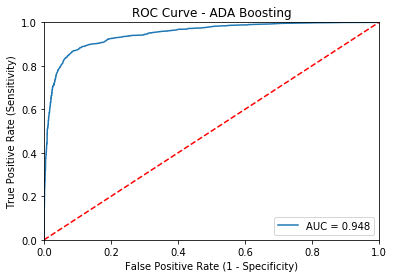

In [121]:
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
preds = clf.predict_proba(features_test)[:,1]

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), preds)
auc = metrics.auc(fpr,tpr)

plt.title("ROC Curve - ADA Boosting")
plt.plot(fpr,tpr,label='AUC = '+ str(round(auc,3)))
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.show()

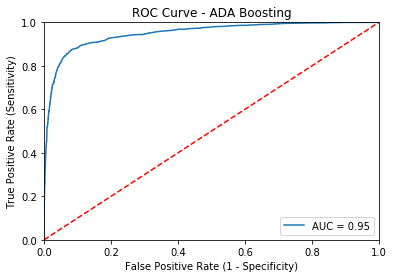

In [122]:
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
preds = clf.predict_proba(features_train)[:,1]

fpr, tpr, _ = metrics.roc_curve(np.array(label_train), preds)
auc = metrics.auc(fpr,tpr)

plt.title("ROC Curve - ADA Boosting")
plt.plot(fpr,tpr,label='AUC = '+ str(round(auc,3)))
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.show()

# Five fold cross validation

In [123]:
from sklearn.model_selection import cross_val_score
clf = AdaBoostClassifier()
scores = cross_val_score(clf, features_train, label_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.93 (+/- 0.01)


In [124]:
clf = LogisticRegression()
scores = cross_val_score(clf, features_train, label_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.81 (+/- 0.00)
